# Churn Prediction
## Load the data

First load the training and test set data.

In [1]:
import pandas as pd

# specify the separator and how to handle missing values
train_set = pd.read_csv('train.csv', sep=',', keep_default_na=True, na_values=[''], engine='c')
test_set = pd.read_csv('test.csv', sep=',', keep_default_na=True, na_values=[''], engine='c')

I saved the IDs of the test set customers so that I can directly
access them later, however the test set customers also have missing
values for the target variable ('churn'). After I saved the test IDs
I can set the 'Customer_ID' variable for both parts.

In [2]:
# save the IDs of the customers from the test set for later
test_Customer_IDs = test_set['Customer_ID']

# make the Customer_ID column the index
train_set.set_index('Customer_ID', inplace=True)
test_set.set_index('Customer_ID', inplace=True)

Next, I concatenate the training and test set into on DataFrame. This makes
preprocessing easy every step is automatically applied to both parts.

In [3]:
# Concatenate the training and test set for easier and
# coherent preprocessing.
data = pd.concat([train_set, test_set], sort=True)

del train_set, test_set

Pandas won't print all columns of the DataFrame since it has
172 columns. Hence, I just print them here one by one:

In [4]:
for col_i, col in enumerate(data.columns):
    print(f"{col_i+1:>3}: {col}")

  1: HHstatin
  2: REF_QTY
  3: actvsubs
  4: adjmou
  5: adjqty
  6: adjrev
  7: adults
  8: age1
  9: age2
 10: area
 11: asl_flag
 12: attempt_Mean
 13: attempt_Range
 14: avg3mou
 15: avg3qty
 16: avg3rev
 17: avg6mou
 18: avg6qty
 19: avg6rev
 20: avgmou
 21: avgqty
 22: avgrev
 23: blck_dat_Mean
 24: blck_dat_Range
 25: blck_vce_Mean
 26: blck_vce_Range
 27: callfwdv_Mean
 28: callfwdv_Range
 29: callwait_Mean
 30: callwait_Range
 31: car_buy
 32: cartype
 33: cc_mou_Mean
 34: cc_mou_Range
 35: ccrndmou_Mean
 36: ccrndmou_Range
 37: change_mou
 38: change_rev
 39: children
 40: churn
 41: comp_dat_Mean
 42: comp_dat_Range
 43: comp_vce_Mean
 44: comp_vce_Range
 45: complete_Mean
 46: complete_Range
 47: crclscod
 48: creditcd
 49: crtcount
 50: csa
 51: custcare_Mean
 52: custcare_Range
 53: da_Mean
 54: da_Range
 55: datovr_Mean
 56: datovr_Range
 57: div_type
 58: drop_blk_Mean
 59: drop_blk_Range
 60: drop_dat_Mean
 61: drop_dat_Range
 62: drop_vce_Mean
 63: drop_vce_Range
 64

## Preprocessing

I define a few lists of variables for selective pre-processing for those
variables.

* `preprocessing_drop` simply drops the variable.
* `categorical_ordered` and `categorical_binary` are label encoded
* `categorical_unordered` are label encoded and then dummy encoded (aka. one-hot encoding)

In [5]:
# variables that are dropped
preprocessing_drop = ['area']  # redundant with 'csa'

# variables that are label encoded ("foo" to 0, "bar" to 1, etc.)
# and then dummy encoded (one-hot encoding)
categorical_unordered = [
    'csa', 'prizm_social_one', 'div_type', 'dualband', 'hnd_webcap',
    'occu1', 'marital', 'cartype', 'HHstatin', 'proptype', 'ethnic',
    'ownrent', 'dwlltype', 'new_cell', 'refurb_new', 'children',
    'infobase', 'mailflag', 'solflag', 'kid0_2', 'kid3_5', 'kid6_10',
    'kid11_15', 'kid16_17','creditcd','car_buy']

# variables that are label encoded
categorical_ordered = ['dwllsize','crclscod']
categorical_binary = ['mailordr','asl_flag','wrkwoman','mailresp','pcowner']

preprocessing_date = ['last_swap']

In the next steps I do all of the preprocessing.

#### Drop variables

In [6]:
try:
    data.drop(preprocessing_drop, axis=1, inplace=True)
except KeyError:
    # catch to allow executing the cell multiple times
    pass

#### Preprocess 'csa'

Make the missing values of the csa column appear at the end
by setting them to 'ZZZZZZ'. Then trunkate all entries in
by to only the first 3 characters. This reduces the number
distinct classes.

In [7]:
data.loc[data.loc[:,'csa'].isnull(), 'csa'] = 'ZZZZZZ'
data['csa'] = data['csa'].map(lambda x: x[:3])

#### Preprocess date columns

Convert the variable from a string to a pandas datetime
column. Then reduce the number of classes in the
categorical variable by limiting the date to year,
month and day.

In [8]:
data.loc[:, 'last_swap'] = pd.to_datetime(data.loc[:, 'last_swap'])
data.loc[:, 'last_swap'] = data.loc[:, 'last_swap'].dt.strftime('%Y-%m-%d')
# TODO: add time since last swap?

In [11]:
# "Missing values for this variable can be assumed to mean there have been no retention calls made by the customer."
data.loc[data.loc[:, 'retdays'].isnull(), 'retdays'] = 0
# assume avg 3 month minutes for missing values in 6 month minutes
data.loc[data.loc[:,'avg6mou'].isnull(), 'avg6mou'] = data.loc[data.loc[:, 'avg6mou'].isnull(), 'avg3mou']
data.loc[data.loc[:,'avg6qty'].isnull(), 'avg6qty'] = data.loc[data.loc[:, 'avg6qty'].isnull(), 'avg3qty']
data.loc[data.loc[:,'avg6rev'].isnull(), 'avg6rev'] = data.loc[data.loc[:, 'avg6rev'].isnull(), 'avg3rev']
# NaNs in age1/age2 should be 0!? ("00 = default")
data.loc[data.loc[:, 'age1'].isnull(), 'age1'] = 0
data.loc[data.loc[:, 'age2'].isnull(), 'age2'] = 0
# "Missing signifies an absence of calls into the retention team." !
data.loc[data.loc[:, 'tot_ret'].isnull(), 'tot_ret'] = 0
# "Missing signifies an absence of an offer from the retention team." -> add '-1' class
data.loc[data.loc[:, 'tot_acpt'].isnull(), 'tot_acpt'] = -1
# "A missing value signifies an absence of referrals" !
data.loc[data.loc[:, 'REF_QTY'].isnull(), 'REF_QTY'] = 0
# assume no credit card rating change for NaNs
data.loc[data.loc[:, 'crtcount'].isnull(), 'crtcount'] = 0
# assume no roaming calls, minutes and revenue for NaNs
data.loc[data.loc[:, 'rmcalls'].isnull(), 'rmcalls'] = 0
data.loc[data.loc[:, 'rmmou'].isnull(), 'rmmou'] = 0
data.loc[data.loc[:, 'rmrev'].isnull(), 'rmrev'] = 0
# if no current/previous handset price is not known assume 0 ?
data.loc[data.loc[:, 'pre_hnd_price'].isnull(), 'pre_hnd_price'] = 0
# if number of cars is not known assume 0 / new class
data.loc[data.loc[:, 'numbcars'].isnull(), 'numbcars'] = 0
# if education is not known create a new class -> 0
data.loc[data.loc[:, 'educ1'].isnull(), 'educ1'] = 0

#### LabelEncode

In [12]:
from sklearn.preprocessing import LabelEncoder

for column in categorical_unordered+categorical_ordered+categorical_binary+preprocessing_date:
    # replace float-NaNs with string 'ZZZ' (as to make sure it is ordered last) for python 3.x
    data.loc[data.loc[:,column].isnull(),column] = 'ZZZZZ'
    data.loc[:,column] = LabelEncoder().fit_transform(data.loc[:,column])

#### RandomForest based NA imputation

In [50]:
from datetime import datetime, timedelta, date

start = datetime.strptime("2018-11-12", "%Y-%m-%d").date()

end = datetime.strptime("2018-12-10", "%Y-%m-%d").date()

dates = (start+timedelta(days) for days in range((end-start).days+1))

In [58]:
from collections import namedtuple
Point = namedtuple('Point', 'Index power_001 power_003, power_004 power_006')
pt1 = Point(1.0, 5.0, 0, 0, 0)
pt2 = Point(2.5, 1.5, 1, 1, 1)
stream_ids = [1, 3, 4, 6]

In [60]:
for s, v in zip(stream_ids, pt1[1:]):
    print(s, v)

1 5.0
3 0
4 0
6 0


In [13]:
categorical_imputation = ('lor', 'income', 'adults', 'truck', 'rv', 'mtrcycle','forgntvl', 'phones', 'models')

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# get a list of tuples (# missing values, column name)
sorted_nans = sorted(
    zip(
        data.loc[:, data.isnull().sum() > 0].isnull().sum(),
        data.loc[:, data.isnull().sum() > 0].columns),
    reverse=True)

# create a generator that yields the column names excep
# for 'churn'. The missing values in the 'churn' variable
# are from the test set!
sorted_gen = (col for missing, col in sorted_nans if col != 'churn')

for column_i, column in enumerate(sorted_gen):
    print(f"{column_i+1:>3}: {column}")

    y = data.loc[:, column]
    X = data.loc[:, [col not in (column, 'churn') for col in data.columns]]

    row_mask = (y.isnull()==0)
    column_mask = X.loc[:,X.isnull().sum()<=0].columns

    if column in categorical_imputation:
        rfc = RandomForestClassifier(
            n_estimators=10, criterion='gini', max_depth=6,
            min_samples_split=2, min_samples_leaf=12, 
            max_features='auto', max_leaf_nodes=None, n_jobs=2)
    else:
        rfc = RandomForestRegressor(
            n_estimators=10, criterion='mse', max_depth=6,
            min_samples_split=2, min_samples_leaf=12, 
            max_features='auto', max_leaf_nodes=None, n_jobs=2)

    rfc.fit(X.loc[row_mask, column_mask], y[row_mask])

    data.loc[~row_mask, column] = rfc.predict(data.loc[~row_mask, column_mask])

print(' DONE')

  1: lor
  2: income
  3: adults
  4: truck
  5: rv
  6: mtrcycle
  7: forgntvl
  8: change_rev
  9: change_mou
 10: hnd_price
 11: vceovr_Range
 12: vceovr_Mean
 13: totmrc_Range
 14: totmrc_Mean
 15: roam_Range
 16: roam_Mean
 17: rev_Range
 18: rev_Mean
 19: ovrrev_Range
 20: ovrrev_Mean
 21: ovrmou_Range
 22: ovrmou_Mean
 23: mou_Range
 24: mou_Mean
 25: datovr_Range
 26: datovr_Mean
 27: da_Range
 28: da_Mean
 29: phones
 30: models
 31: eqpdays
 DONE


#### Dummy Encode variables

In [12]:
n_columns_prev = len(data.columns)

data = pd.get_dummies(
    data=data, dummy_na=False,
    columns=categorical_unordered)

print(f"went from {n_columns_prev-1} to {len(data.columns)-1} variables")

went from 170 to 335 variables


#### Clean Remaining NaNs

In [13]:
# remove columns which still have more than 250 (0.5%) missing values
threashold = 250

n_columns_prev = len(data.columns)
n_missing = data.isnull().sum()

print(data.loc[:, (m > threashold and c != 'churn' for m, c in zip(n_missing, data.columns))].columns)
data = data.loc[:, (m <= threashold or c == 'churn' for m, c in zip(n_missing, data.columns))]

print(f"{len(data.columns)-1} / {n_columns_prev-1} variables left")

Index([], dtype='object')
335 / 335 variables left


At this point there are no rows with missing values anymore:

In [14]:
(data.loc[:, (c for c in data.columns if c != 'churn')].isnull().sum(axis=1) > 0).sum()

0

#### Scale Dataset

In [15]:
from sklearn.preprocessing import StandardScaler

StdScaler = StandardScaler(copy=True)
StdScaler = StdScaler.fit(data.loc[:, data.columns != 'churn'])
data.loc[:, data.columns != 'churn'] = StdScaler.transform(data.loc[:, data.columns != 'churn'])

C:\Users\RadmerT\AppData\Local\Continuum\miniconda3\envs\ml\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\RadmerT\AppData\Local\Continuum\miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  """


#### Split dataset & optimize layout

In [16]:
X_mask = [True if c != 'churn' else False for c in data.columns]
y_mask = [True if c == 'churn' else False for c in data.columns]

X_tr = data.iloc[:int(len(data)/2), X_mask].values.astype('float32')
y_tr = data.iloc[:int(len(data)/2), y_mask].values.astype('float32')

X_te = data.iloc[int(len(data)/2):, X_mask].values.astype('float32')
y_te = data.iloc[int(len(data)/2):, y_mask].values.astype('float32')

del data

#### Generate Cross-Validation Splits

In [17]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
data_splits = [(X_tr[tr], X_tr[va], y_tr[tr], y_tr[va]) for tr, va in kf.split(X_tr)]

# Train Classifiers
#### Define Scoring Function

In [32]:
import numpy as np

def calcLift(y, y_proba, percentile=0.1):
    if len(np.shape(y_proba)) == 2:
        y_lift = sorted(zip(y_proba[:,1], y), reverse=True)
    else:
        y_lift = sorted(zip(y_proba, y), reverse=True)
    y_lift = [list(t) for t in zip(*y_lift)][1]
    y_lift = y_lift[0:np.int32(len(y_lift)*percentile)]

    Pi10 = np.sum(y_lift)/len(y_lift)
    PiAll = np.sum(y)/len(y)
    Lift10 = Pi10/PiAll
    return Lift10

def liftScorer(estimator, X, y):
    y_proba = None
    if hasattr(estimator, 'predict_proba'):
        y_proba = estimator.predict_proba(X)
    elif hasattr(estimator, 'decision_function'):
        y_proba = estimator.decision_function(X)
    else:
        return 0.0
    return calcLift(y, y_proba)

def calcLiftCurve(y, y_proba):
    PiAll_inv = 1.0/(np.sum(y)/len(y))
    
    if len(np.shape(y_proba)) == 2:
        y_lift = sorted(zip(y_proba[:,1],y),reverse=True)
    else:
        y_lift = sorted(zip(y_proba,y),reverse=True)
    y_lift = [list(t) for t in zip(*y_lift)][1]
    
    x_axis = np.linspace(0.0, 1.0, 101)
    y_axis = np.zeros(np.shape(x_axis), dtype=np.float32)
    for i, percentile in enumerate(x_axis):
        y_percentile = y_lift[0:np.int32(len(y_lift)*percentile)]
        y_axis[i] = (np.sum(y_percentile)/len(y_percentile))*PiAll_inv
    return x_axis, y_axis

#### Functions for Printing Results

In [57]:
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline

def printLiftMeasureCV(scores):
    print(u'{0:2.0f}% Lift Measure:\t[{3:.3f}, {1:.3f}\u00B1{2:0.3f}, {4:.3f}]\n'
          .format(0.1*100, np.mean(scores), np.std(scores), np.min(scores), np.max(scores)))
    
def printClassificationReport(y_pred, y_true, target_names=('NO CHURN', 'CHURN')):
    print('Classification Report:\n\n', classification_report(y_true, y_pred, target_names=target_names))
    
def printVariableImportance(feature_importances, column_names):
    importance = sorted(zip(feature_importances, column_names), reverse=True)
    f1, f2, f3, f4, f5 = importance[0:20], importance[20:40], importance[40:60], importance[60:80], importance[80:100]
    print('\nTop100 Variable Importance:\n')
    for r1,r2,r3,r4,r5 in zip(f1,f2,f3,f4,f5):
        print('{0:.2f} {1:17} {2:.2f} {3:17} {4:.2f} {5:17} {6:.2f} {7:17} {8:.2f} {9:17}'
              .format(r1[0],r1[1][0:21],r2[0],r2[1][0:21],r3[0],r3[1][0:21],r4[0],r4[1][0:21],r5[0],r5[1][0:21]))
        
def plot_confusion_matrix(cm, axis, title='Confusion matrix', cmap=plt.cm.Blues, target_names=['NO CHURN', 'CHURN']):
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm_norm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for i in [0,1]:
        for j in [0,1]:
            axis.annotate(str('{0}\n({1:.2f})'.format(cm[j][i], cm_norm[j][i])), xy=(i-0.1,j+0.06))

#### Save/Load Models

In [26]:
import pickle

def saveModel(model, model_name):
    with open(model_name, 'wb') as f:
        pickle.dump(model, f)
        
def loadModel(model_name):
    with open(model_name, 'rb') as f:
        return pickle.load(f)

### Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

if __name__ == "__main__":
    LogReg = LogisticRegression(
        penalty='l2', tol=0.0001,
        class_weight=None, random_state=None,
        solver='lbfgs', max_iter=100, 
        dual=False, # n_samples > n_features?False:True
        C=100.0)

    lift_scores = cross_val_score(
        LogReg, X_tr, y=y_tr, scoring=liftScorer, 
        cv=10, n_jobs=2, verbose=0, pre_dispatch='2*n_jobs')

    printLiftMeasureCV(lift_scores)
    
    LogReg.fit(X_tr, y_tr)

    saveModel(LogReg, 'model.LogReg')

10% Lift Measure:	[1.254, 1.308±0.054, 1.361]



C:\Users\RadmerT\AppData\Local\Continuum\miniconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\RadmerT\AppData\Local\Continuum\miniconda3\envs\ml\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [49]:
LogReg = loadModel('model.LogReg')

x_lift_curve, y_lift_curve_lr = calcLiftCurve(y_te, LogReg.predict_proba(X_te))

y_pred = LogReg.predict(X_tr)
printClassificationReport(y_pred, y_tr)
printVariableImportance(LogReg.coef_[0], train_set.loc[:,train_set.columns != 'churn'].columns)

C:\Users\RadmerT\AppData\Local\Continuum\miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


Classification Report:

               precision    recall  f1-score   support

    NO CHURN       0.61      0.62      0.61     25219
       CHURN       0.60      0.59      0.60     24781

   micro avg       0.61      0.61      0.61     50000
   macro avg       0.61      0.61      0.61     50000
weighted avg       0.61      0.61      0.61     50000


Top100 Variable Importance:

1.98 phones            0.14 cc_mou_Range      0.03 mouiwylisv_Range  0.01 unan_dat_Mean     -0.00 age1             
1.40 totmrc_Mean       0.14 cc_mou_Mean       0.03 mou_opkd_Mean     0.01 recv_sms_Mean     -0.00 kid16_17         
0.93 rev_Range         0.14 blck_dat_Mean     0.03 mtrcycle          0.01 recv_sms_Range    -0.00 mailflag         
0.93 avgrev            0.12 adjmou            0.03 solflag           0.01 kid6_10           -0.00 peak_dat_Mean    
0.84 recv_vce_Mean     0.12 prizm_social_one  0.02 plcd_vce_Mean     0.01 asl_flag          -0.00 peak_vce_Mean    
0.34 roam_Range        0.11 vceovr_Ran

### Gaussian Naive Bayes

In [51]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

if __name__ == "__main__":
    GaussNB = GaussianNB()
    # CalGaussNB = CalibratedClassifierCV(base_estimator=GaussNB, method='isotonic', cv=4)
    
    lift_scores = cross_val_score(
        GaussNB, X_tr, y=y_tr, scoring=liftScorer, 
        cv=10, n_jobs=2, verbose=0, pre_dispatch='2*n_jobs')
    printLiftMeasureCV(lift_scores)
    
    GaussNB.fit(X_tr, y_tr)

    saveModel(GaussNB, 'model.GaussNB')

10% Lift Measure:	[1.088, 1.856±0.327, 2.018]



C:\Users\RadmerT\AppData\Local\Continuum\miniconda3\envs\ml\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


C:\Users\RadmerT\AppData\Local\Continuum\miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less
C:\Users\RadmerT\AppData\Local\Continuum\miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


Classification Report:

               precision    recall  f1-score   support

    NO CHURN       0.62      0.07      0.12     25219
       CHURN       0.50      0.96      0.66     24781

   micro avg       0.51      0.51      0.51     50000
   macro avg       0.56      0.51      0.39     50000
weighted avg       0.56      0.51      0.39     50000


Top100 Variable Importance:

0.23 callwait_Mean     0.02 cc_mou_Range      0.01 retdays           -0.01 peak_vce_Range    -0.01 avg6mou          
0.14 pre_hnd_price     0.02 solflag           0.01 blck_dat_Mean     -0.01 creditcd          -0.01 blck_vce_Mean    
0.12 hnd_price         0.02 blck_vce_Range    0.01 kid6_10           -0.01 owylis_vce_Range  -0.02 kid3_5           
0.09 dwlltype          0.02 attempt_Range     0.00 age2              -0.01 avg3qty           -0.02 mailflag         
0.07 mailordr          0.02 prizm_social_one  0.00 mou_peav_Range    -0.01 drop_dat_Mean     -0.02 drop_vce_Range   
0.07 crclscod          0.02 div_t

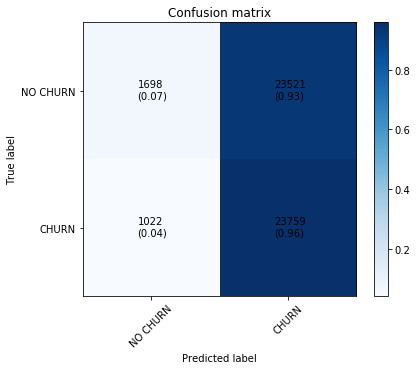

In [59]:
GaussNB = loadModel('model.GaussNB')

x_lift_curve, y_lift_curve_gnb = calcLiftCurve(y_te, GaussNB.predict_proba(X_te))

y_pred = GaussNB.predict(X_tr)
printClassificationReport(y_pred, y_tr)
printVariableImportance(GaussNB.theta_[1]-GaussNB.theta_[0],train_set.loc[:,train_set.columns != 'churn'].columns)
print('\n')

plt.figure(figsize=(6,5))
ax2 = plt.subplot(1,1,1)
plot_confusion_matrix(confusion_matrix(y_tr, y_pred), ax2, title='Confusion matrix')

### Linear SVM

In [62]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

if __name__ == "__main__":
    LinSVM = LinearSVC(
        penalty='l2', 
        loss='squared_hinge', 
        dual=False, # n_samples > n_features
        tol=0.0001, 
        C=0.1, 
        fit_intercept=True, 
        class_weight=None, 
        max_iter=100)

    lift_scores = cross_val_score(
        LinSVM, X_tr, y=y_tr, scoring=liftScorer, 
        cv=10, n_jobs=2, verbose=0, pre_dispatch='2*n_jobs')

    printLiftMeasureCV(lift_scores)   

    x_lift_curve, y_lift_curve_linsvm = calcLiftCurve(y_tr, LinSVM.decision_function(X_tr))

    LinSVM.fit(X_tr, y_tr)

    saveModel(LinSVM, 'model.LinSVM') 

10% Lift Measure:	[1.291, 1.367±0.048, 1.441]



NotFittedError: This LinearSVC instance is not fitted yet

In [ ]:
LinSVM = loadModel('model.LinSVM')

y_pred = LinSVM.predict(X_tr)
printClassificationReport(y_pred, y_tr)
printVariableImportance(LinSVM.coef_[0], train_set.loc[:,train_set.columns != 'churn'].columns)

### Random Forest

In [ ]:
if __name__ == "__main__":
    # train RandomForest
    RandomForest = RandomForestClassifier(
        n_estimators=50, 
        criterion='gini', 
        max_depth=5,
        min_samples_split=2, 
        min_samples_leaf=1, 
        max_features='auto', 
        max_leaf_nodes=None, 
        n_jobs=1)

    lift_scores = cross_val_score(
        RandomForest,
        X_full, y=y_full,
        scoring=liftScorer, cv=10,
        n_jobs=4, verbose=0, pre_dispatch='2*n_jobs')
    printLiftMeasureCV(lift_scores)

    RandomForest.fit(X_tr, y_tr)
    
    x_lift_curve, y_lift_curve_rf = calcLiftCurve(y_te, RandomForest.predict_proba(X_te))

    y_pred = RandomForest.predict(X_te)
    printClassificationReport(y_pred, y_te, target_names)
    printVariableImportance(RandomForest.feature_importances_, train_set.loc[:,train_set.columns != 'churn'].columns)

    saveModel(RandomForest, 'model.RandomForest')

#### Gradient Boosting Classifier
I created a script that evaluates the classifier after each boosting
iteration and plots the learning curve. This helps to evaluate if the
enough boosting iterations are made.

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

import numpy as np

from sklearn.base import clone
from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier


def gbcEvaluation(estimator, Xtr, ytr, Xva, yva):
    '''Evaluates a a GradientBoostingClassifier `estimator`
    at every boosting iteration.
    
    Returns a tuple with
    * the `estimator`
    * the f1 score for each boosting iteration
    * the loss for each boosting iteration
    * the lift score for each boosting iteration
    * the predictions for each boosting iteration
    * the true labels `yva`
    '''
    estimator.fit(Xtr,ytr)
    
    iterations = estimator.get_params()['n_estimators']
    
    # Calculate the predictions and f1-score for each 
    # boosting iteration.
    yva_preds = np.zeros((iterations, len(yva)))
    f1 = np.zeros((iterations,), dtype=np.float32)
    for l, yva_pred in enumerate(estimator.staged_predict(Xva)):
        yva_preds[l,:] = y_pred
        f1[l] = f1_score(yva, yva_pred)

    # Calculate the loss (e.g. the 'deviance') for each
    # boosting iteration.
    loss = np.zeros((iterations,), dtype=np.float32)
    for i, yva_loss in enumerate(estimator.staged_decision_function(Xva)):
        loss[i] = estimator.loss_(yva, yva_loss)

    # Calculate the lift score for the 10% of the customers
    # from the validaiton set with the highest predicted churn
    # score for each boosting iteration.
    lift = np.zeros((iterations,), dtype=np.float32)
    for j, yva_prob in enumerate(estimator.staged_predict_proba(Xva)):
        lift[j] = calcLift(yva, yva_prob)

    return (estimator, f1, loss, lift, yva_preds, yva)

if __name__ == "__main__":
    gbc = GradientBoostingClassifier(
        loss='deviance', 
        learning_rate=0.1, 
        n_estimators=200, 
        min_samples_split=2, 
        min_samples_leaf=1, 
        max_depth=6, 
        subsample=0.5, 
        max_features=None, 
        max_leaf_nodes=None, 
        warm_start=False,
        presort='auto',
        verbose=0)

    iterations = gbc.get_params()['n_estimators']

    estimators = []
    y_true = []
    f1 = np.zeros((iterations,), dtype=np.float32)
    loss = np.zeros((iterations,), dtype=np.float32)
    lift = np.zeros((iterations,len(data_splits)), dtype=np.float32)
    y_predicts = [np.zeros((iterations,len(y_te)), dtype=np.float32) for i in range(0,len(data_splits))]
    
    start_time = time.time()

    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_scores = {
            executor.submit(gbcEvaluation, clone(gbc), Xtr, ytr, Xva, yva):
                (Xtr, Xva, ytr, yva)
            for (Xtr, Xva, ytr, yva) in data_splits
        }

        for k, future in enumerate(as_completed(future_to_scores)):
            try:
                res_scores = future.result()
            except Exception as exc:
                print(f"ERROR:{exc}")
            else:
                estimators.append(res_scores[0])
                f1 += res_scores[1]
                loss += res_scores[2]
                lift[:,k] = res_scores[3]
                y_predicts[k] = res_scores[4]
                y_true.append(res_scores[5])

    run_time = time.time()-start_time
    print(f"runtime: {run_time:.1f} s")
    
    # average the results
    f1 /= len(estimators)
    loss /= len(estimators)
    y_predicts = np.concatenate(y_predicts, axis=1)
    y_true = np.concatenate(y_true)
    
    # fit individual model for prediction of test dataset
    gbc.fit(X_full, y_full)
    saveModel([gbc, estimators], 'model.GradientBoosting')
    
    x_lift_curve, y_lift_curve_gbc = calcLiftCurve(
        y_te, gbc.predict_proba(X_te))
    
    # print average lift scores with min, max, and std
    argmax_lift = np.argmax(np.mean(lift,axis=1), axis=0)
    print('Score after {0} boosting iterations:\n'.format(len(lift)))
    printLiftMeasureCV(lift[-1])
    printClassificationReport(y_predicts[argmax_lift], y_true, target_names)
    printVariableImportance(np.mean([x.feature_importances_ for x in estimators],axis=0), train_set.columns[train_set.columns != 'churn'])
    print('\n')
    
    # plot train and test set deviance after each boosting iteration
    plt.figure(figsize=(15,10))
    plt.subplot(2,2,1)
    plt.title('Deviance')
    plt.plot(np.arange(iterations)+1, np.mean([x.train_score_ for x in estimators], axis=0), 'r-', label='deviance on training set')
    plt.plot(np.arange(iterations)+1, loss, 'b-', label='deviance on test set')
    plt.legend(loc='upper right')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Deviance')    
    # plot F1 measure after each boosting iteration
    plt.subplot(2,2,2)
    plt.title('F1 Score')
    plt.plot(np.arange(iterations)+1, f1, 'b-', label='F1 score on test set')
    plt.legend(loc='lower right')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('F1')
    # plot 10% lift measure after every boosting iteration
    plt.subplot(2,2,3)
    plt.title('Lift Score')
    plt.plot(np.arange(iterations)+1, np.mean(lift, axis=1), 'b-', label='10%-lift on test set')
    plt.legend(loc='lower right')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Lift')
    # plot confusion matrix
    ax2 = plt.subplot(2,2,4)
    plot_confusion_matrix(confusion_matrix(y_true,y_predicts[-1]), ax2, title='Confusion matrix ({0} iter.)'.format(len(lift)))

### RBF SVM

In [ ]:
if __name__ == "__main__":
    rbfSVM = SVC(C=1.0, 
                 kernel='rbf', 
                 probability=False, 
                 gamma='auto', # 1/n_features
                 tol=0.001, 
                 cache_size=200)
    
    lift_scores = cross_val_score(rbfSVM, X_full, y=y_full, scoring=liftScorer, 
                             cv=10, n_jobs=4, verbose=0, pre_dispatch='2*n_jobs')
    printLiftMeasureCV(lift_scores)
    
    rbfSVM.fit(X_tr, y_tr)
    
    x_lift_curve, y_lift_curve_rbfsvm = calcLiftCurve(y_te, rbfSVM.decision_function(X_te))
    
    y_pred = rbfSVM.predict(X_te)
    printClassificationReport(y_pred, y_te, target_names)
    
    saveModel(rbfSVM, 'model.rbfSVM')

# Plot Lift Curves

In [ ]:
plt.figure(figsize=(15,10))
# plt.subplot(2,2,1)
plt.title('Lift Curves')
plt.plot(x_lift_curve, y_lift_curve_gbc, 'r-', label='Gradient Boosting Trees')
plt.plot(x_lift_curve, y_lift_curve_rf, 'b-', label='Random Forest')
plt.plot(x_lift_curve, y_lift_curve_lr, 'g-', label='Logistic Regression')
plt.plot(x_lift_curve, y_lift_curve_linsvm, 'k-', label='Linear SVM')
# plt.plot(x_lift_curve, y_lift_curve_rbfsvm, 'c-', label='Gaussian Naive Bayes')
plt.plot(x_lift_curve, y_lift_curve_gnb, 'm-', label='Gaussian Naive Bayes')

plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')  

# Predict Test Set

In [ ]:
# test_set.drop('churn',axis=1,inplace=True)
# test_set = np.asfortranarray(test_set.values, dtype=np.float32)

y_test_proba = gbc.predict_proba(test_set)

y_test_proba = pandas.DataFrame(y_test_proba[:,1], index=test_Customer_IDs)
y_test_proba.columns = ['EstimatedChurnProbability']

y_test_proba.to_csv('BADS_Test_Predictions_GBC.csv')

#### Load Libraries & Define Functions

In [ ]:
from sklearn.base import clone
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectPercentile, f_classif, SelectKBest
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report, f1_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, FeatureUnion
from scipy.stats import spearmanr
import pickle
import time
from IPython.display import clear_output

def liftScorer(estimator, X, y):
    y_proba = None
    if hasattr(estimator, 'predict_proba'):
        y_proba = estimator.predict_proba(X)
    elif hasattr(estimator, 'decision_function'):
        y_proba = estimator.decision_function(X)
    else:
        return 0.0
    return calcLift(y, y_proba)

def calcLift(y, y_proba, percentile=0.1):
    if len(np.shape(y_proba)) == 2:
        y_lift = sorted(zip(y_proba[:,1],y),reverse=True)
    else:
        y_lift = sorted(zip(y_proba,y),reverse=True)
    y_lift = [list(t) for t in zip(*y_lift)][1]
    y_lift = y_lift[0:np.int32(len(y_lift)*percentile)]

    Pi10 = np.sum(y_lift)/len(y_lift)
    PiAll = np.sum(y)/len(y)
    Lift10 = Pi10/PiAll
    return Lift10

def calcLiftCurve(y, y_proba):
    PiAll_inv = 1.0/(np.sum(y)/len(y))
    
    if len(np.shape(y_proba)) == 2:
        y_lift = sorted(zip(y_proba[:,1],y),reverse=True)
    else:
        y_lift = sorted(zip(y_proba,y),reverse=True)
    y_lift = [list(t) for t in zip(*y_lift)][1]
    
    x_axis = np.linspace(0.0, 1.0, 101)
    y_axis = np.zeros(np.shape(x_axis), dtype=np.float32)
    for i, percentile in enumerate(x_axis):
        y_percentile = y_lift[0:np.int32(len(y_lift)*percentile)]
        y_axis[i] = (np.sum(y_percentile)/len(y_percentile))*PiAll_inv
    return x_axis, y_axis

def printLiftMeasureCV(scores):
    print(u'{0:2.0f}% Lift Measure:\t[{3:.3f}, {1:.3f}\u00B1{2:0.3f}, {4:.3f}]\n'
          .format(0.1*100, np.mean(scores), np.std(scores), np.min(scores), np.max(scores)))
    
def printClassificationReport(y_pred, y_true, target_names):
    print('Classification Report:\n\n', classification_report(y_true, y_pred, target_names=target_names))
    
def printVariableImportance(feature_importances, column_names):
    importance = sorted(zip(feature_importances, column_names), reverse=True)
    f1, f2, f3, f4, f5 = importance[0:20], importance[20:40], importance[40:60], importance[60:80], importance[80:100]
    print('\nTop100 Variable Importance:\n')
    for r1,r2,r3,r4,r5 in zip(f1,f2,f3,f4,f5):
        print('{0:.2f} {1:21} {2:.2f} {3:21} {4:.2f} {5:21} {6:.2f} {7:21} {8:.2f} {9:21}'
              .format(r1[0],r1[1][0:21],r2[0],r2[1][0:21],r3[0],r3[1][0:21],r4[0],r4[1][0:21],r5[0],r5[1][0:21]))
        
def plot_confusion_matrix(cm, axis, title='Confusion matrix', cmap=plt.cm.Blues, target_names=['NO CHURN', 'CHURN']):
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm_norm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for i in [0,1]:
        for j in [0,1]:
            axis.annotate(str('{0}\n({1:.2f})'.format(cm[j][i], cm_norm[j][i])), xy=(i-0.1,j+0.06))
        
def saveModel(model, model_name):
    with open(model_name, 'wb') as f:
        pickle.dump(model, f)
        
def loadModel(model_name):
    with open(model_name, 'rb') as f:
        return pickle.load(f)
        
def generateTrainTestSplit(dataset, test_percent=0.1):
    # split the data set into training and test
    X_tr, X_te, y_tr, y_te = train_test_split(dataset.loc[:,[col for col in dataset.columns if col not in ['churn']]],
                                              dataset.loc[:,[col for col in dataset.columns if col in ['churn']]], 
                                              test_size=test_percent, 
                                              stratify=dataset.loc[:,[col for col in dataset.columns if col in ['churn']]])

    X_tr = np.asfortranarray(X_tr.values, dtype=np.float32)
    X_te = np.asfortranarray(X_te.values, dtype=np.float32)
    y_tr = np.ravel(np.asfortranarray(y_tr.values, dtype=np.float32))
    y_te = np.ravel(np.asfortranarray(y_te.values, dtype=np.float32))
    
    return X_tr, X_te, y_tr, y_te

# Load & Preprocess Datasets

In [ ]:
StdScaler = StandardScaler(copy=True)
StdScaler = StdScaler.fit(data.loc[:,data.columns != 'churn'])
data.loc[:, data.columns != 'churn'] = StdScaler.transform(data.loc[:,data.columns != 'churn'])

train_set = data.iloc[:len(data)/2,:]
test_set = data.iloc[len(data)/2:,:]

del data

# Save or Load Dataset

In [ ]:
try:
    train_set
except NameError:
    with open('train.data', 'rb') as f:
        train_set = pickle.load(f)
else:
    if train_set is not None:
        with open('train.data', 'wb') as f:
            pickle.dump(train_set, f)
    else:
        with open('train.data', 'rb') as f:
            train_set = pickle.load(f)

try:
    test_set
except NameError:
    with open('test.data', 'rb') as f:
        test_set = pickle.load(f)
else:
    if test_set is not None:
        with open('test.data', 'wb') as f:
            pickle.dump(test_set, f)
    else:
        with open('test.data', 'rb') as f:
            test_set = pickle.load(f)

In [ ]:
# give classes a name
target_names = ('NO CHURN', 'CHURN')

data_splits = []

for splt in range(0,4):
    data_splits.append(generateTrainTestSplit(train_set))

X_tr, X_te, y_tr, y_te = generateTrainTestSplit(train_set)

# also create a full version for cross-validation
X_full = np.asfortranarray(train_set.loc[:,train_set.columns != 'churn'].values, dtype=np.float32)
y_full = np.ravel(np.asfortranarray(train_set.loc[:,train_set.columns == 'churn'].values, dtype=np.float32))

# BACKUP

#### Reduce dataset to important features

In [ ]:
# with open('train.data', 'rb') as f:
#     data = pickle.load(f)
# len(data.columns)

# subset_columns = ['csa','eqpdays','ethnic','months','change_mou','mou_Range','adjrev','mou_Mean','totrev','avgrev','churn']
# data = data[subset_columns]
# len(data.columns)

# dummy_mask = [x if (x in data.columns) else None for x in (many_unordered+two_plus_missing)]
# dummy_columns = []
# for column in dummy_mask:
#     if column != None:
#         dummy_columns.append(column)
# dummy_columns

#### Grid Search Code

In [ ]:
#     param_grid = dict(max_depth=[3, 9], min_samples_leaf=[1, 50], max_features=[1.0, 0.3])
#     grid_search = GridSearchCV(gbc, scoring=scorer, param_grid=param_grid, verbose=3, cv=3, n_jobs=2, pre_dispatch=3)
#     grid_search.fit(X_tr,y_tr)
#     print(grid_search.grid_scores_)

#### Simple Gradient Boosting Evaluation

In [ ]:
# if __name__ == "__main__":
#     gbc = GradientBoostingClassifier(loss='deviance', 
#                                      learning_rate=0.1, 
#                                      n_estimators=50, 
#                                      min_samples_split=2, 
#                                      min_samples_leaf=1, 
#                                      max_depth=6, 
#                                      subsample=0.5, 
#                                      max_features=None, 
#                                      max_leaf_nodes=None, 
#                                      warm_start=False, presort='auto', verbose=0)
#     lift_scores = cross_val_score(gbc, X_full, y=y_full, scoring=liftScorer, 
#                          cv=10, n_jobs=2, verbose=1, pre_dispatch='2*n_jobs')
#     printLiftMeasureCV(lift_scores)

#     gbc.fit(X_tr, y_tr)
#     y_pred = gbc.predict(X_te)
#     printClassificationReport(y_pred, y_te, target_names)
#     printVariableImportance(gbc.feature_importances_, data.loc[:,data.columns != 'churn'].columns)

#     saveModel(gbc, 'GradientBoostingClassifier')